In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

plt.style.use("seaborn")

In [2]:
def read_txt_array(fp):
    with open(fp) as fh:
        lines = fh.read().splitlines()
    return np.stack([[float(num) for num in line.split(",")] for line in lines])

## Boolean LP

In [3]:
A = read_txt_array("data/matrix_A.txt")
c = read_txt_array("data/vector_c.txt")

In [4]:
n = 100
m = 300
b = A @ np.ones((n, 1)) / 2

In [5]:
x = cp.Variable((n, 1))
objective = cp.Minimize(c.T @ x)
constraints = [0 <= x, x <= 1, A @ x <= b]
prob = cp.Problem(objective, constraints)

result = prob.solve()

In [6]:
print("Lower bound on p*:", objective.value)

Lower bound on p*: -33.16723960901254


Text(0.5, 1.0, 'Max constraint violation for different thresholds\n ie <0 implies that rounding is feasible')

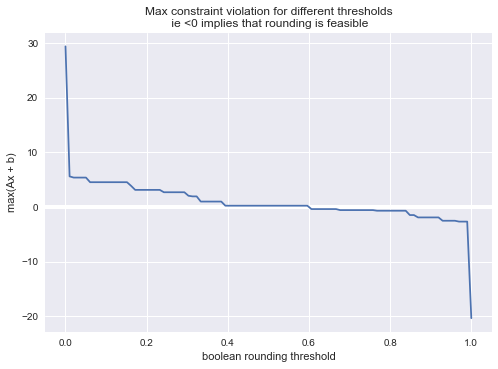

In [7]:
t = np.linspace(0, 1, 100)

max_constraint_violation = (A @ (x.value >= t).astype(int) - b).max(axis=0)

ax = plt.gca()
ax.plot(t, max_constraint_violation)
ax.axhline(0, color="white", zorder=-1, lw=4)
ax.set_ylabel("max(Ax + b)")
ax.set_xlabel("boolean rounding threshold")
ax.set_title("Max constraint violation for different thresholds\n ie <0 implies that rounding is feasible")

In [8]:
is_feasible = max_constraint_violation <= 0

In [9]:
values = (c.T @ (x.value > t).astype(int))
upper_bound = values[0, :][is_feasible].min()

In [10]:
print("Gap between upper and lower bound on p*:", upper_bound - objective.value)

Gap between upper and lower bound on p*: 0.7222088659125347


## Simple portfolio optimization

In [11]:
S = read_txt_array("data/matrix_S.txt")
p_bar = read_txt_array("data/vector_pbar.txt")
n = p_bar.shape[0]

In [12]:
uniform_portfolio = np.ones(n) / n
uniform_expected_return = (p_bar.T @ uniform_portfolio)[0]

In [13]:
uniform_portfolio_risk = uniform_portfolio.T @ S @ uniform_portfolio
print("Uniform portfolio risk: ", np.sqrt(uniform_portfolio_risk))

Uniform portfolio risk:  0.08703595741224256


In [14]:
x = cp.Variable(n)
objective = cp.Minimize(cp.quad_form(x, S))
constraints = [np.ones(n) @ x == 1, p_bar.T @ x == uniform_expected_return]
prob = cp.Problem(objective, constraints)

result = prob.solve()
print(f"Optimal portfolio risk: {np.sqrt(objective.value)}")

Optimal portfolio risk: 0.018607150257670024


In [15]:
x = cp.Variable(n)
objective = cp.Minimize(cp.quad_form(x, S))
constraints = [np.ones(n) @ x == 1, p_bar.T @ x >= uniform_expected_return, x >= 0]
prob = cp.Problem(objective, constraints)

result = prob.solve()
print(f"Optimal long-only portfolio risk: {np.sqrt(objective.value)}")

Optimal long-only portfolio risk: 0.050658217975691526


In [16]:
x = cp.Variable(n)
objective = cp.Minimize(cp.quad_form(x, S))
constraints = [
    np.ones(n) @ x == 1,
    p_bar.T @ x >= uniform_expected_return,
    np.ones(n) @ cp.maximum(-x, 0) <= 0.5
    
]
prob = cp.Problem(objective, constraints)

result = prob.solve()
print(f"Optimal limited total-short position portfolio risk: {np.sqrt(objective.value)}")

Optimal limited total-short position portfolio risk: 0.020994685491867865
